## Checklist för machinelearning
1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data
5. Explore models and chose the best one
6. Fine-tune models
7. Present solution
8. Launch

In [18]:
import joblib
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score



### Importering och uppdelning av data

In [19]:
mnist = fetch_openml('mnist_784', version =1, cache = True, as_frame = False)

In [20]:
X = mnist["data"]
X = X.reshape(X.shape[0], 784)
X = X.astype('float32') / 255.0

y = mnist["target"].astype(np.uint8)

print(y[0])

5


In [21]:
# Delar upp datan i träning, validering och test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=11)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=11)

### Modellering av data

In [22]:
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=11)
extra_trees_clf.fit(X_train, y_train)
extra_trees_clf_pred=extra_trees_clf.predict(X_val)


In [23]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=700, n_jobs=-1)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_val)

In [24]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=11)
random_forest_clf.fit(X_train, y_train)
random_forest_clf_pred=random_forest_clf.predict(X_val)



In [25]:
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('rf', random_forest_clf), ('ext', extra_trees_clf)], voting='hard')
voting_clf.fit(X_train, y_train)
voting_clf_pred = voting_clf.predict(X_val) 

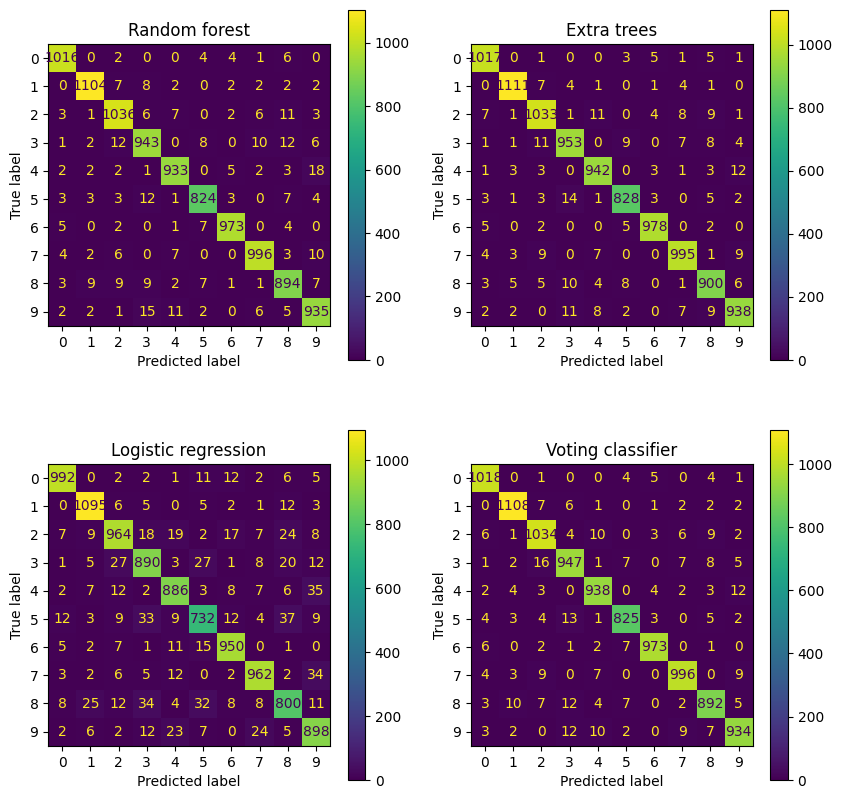

In [26]:
cm1 = confusion_matrix(y_val, random_forest_clf_pred)
cm2 = confusion_matrix(y_val, extra_trees_clf_pred)
cm3 = confusion_matrix(y_val, log_reg_pred)
cm4 = confusion_matrix(y_val, voting_clf_pred)

fig, axs = plt.subplots(2, 2, figsize = (10, 10))
ConfusionMatrixDisplay(cm1).plot(ax=axs[0,0])
ConfusionMatrixDisplay(cm2).plot(ax=axs[0,1])
ConfusionMatrixDisplay(cm3).plot(ax=axs[1,0])
ConfusionMatrixDisplay(cm4).plot(ax=axs[1,1])
axs[0,0].title.set_text('Random forest')
axs[0,1].title.set_text('Extra trees')
axs[1,0].title.set_text('Logistic regression')
axs[1,1].title.set_text('Voting classifier')

In [28]:
print(accuracy_score(y_val, random_forest_clf_pred))
print(accuracy_score(y_val, extra_trees_clf_pred))
print(accuracy_score(y_val, log_reg_pred))
print(accuracy_score(y_val, voting_clf_pred))


0.9654
0.9695
0.9169
0.9665


## Går vidare med Random forest

In [31]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10]
}

rf_w_grid_search = GridSearchCV(random_forest_clf, param_grid, cv=3,
    scoring='accuracy')
rf_w_grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=11),
             param_grid={'max_depth': [20, 30, 40],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

In [32]:
print(accuracy_score(y_test, rf_w_grid_search.predict(X_test)))
print(rf_w_grid_search.best_params_)

0.9694
{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}


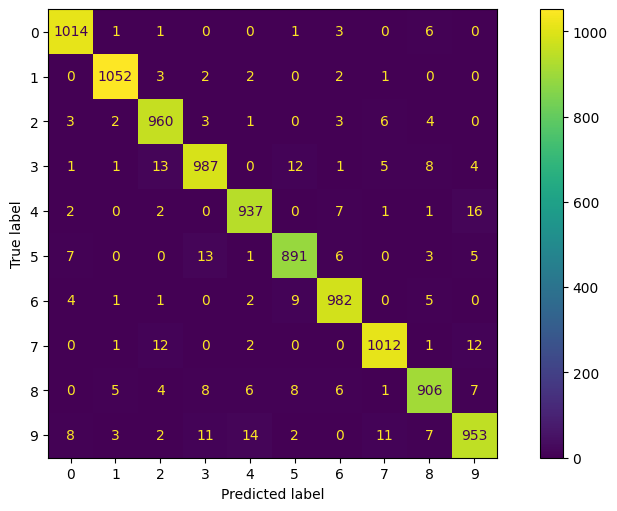

In [33]:
cm5 = confusion_matrix(y_test, rf_w_grid_search.predict(X_test))
fig, axs = plt.subplots(1, 1, figsize = (10, 5), layout = 'constrained')
ConfusionMatrixDisplay(cm5).plot(ax=axs)

In [34]:
model = rf_w_grid_search.fit(X, y)

In [35]:
joblib.dump(model, "rf_model_trained.pkl")

['rf_model_trained.pkl']